In [1]:
# Import packages
import os
import pathlib
import zipfile

import geopandas as gpd
from IPython.display import clear_output
import load_model
import matplotlib.pyplot as plt
import numpy as np
from riverrem.REMMaker import REMMaker, clear_osm_cache
import requests
import rioxarray as rxr
from rioxarray.merge import merge_arrays
from time import sleep

In [2]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'st-vrain-rem-wkdir', 'data')

# Try/Except Block   
try:
    os.chdir(working_dir)
except:
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    os.chdir(working_dir)
else:
    print('{} is now the working directory'.format(working_dir))

/Users/lchipman/st-vrain-rem-wkdir/data is now the working directory


# Load the site information into dictionaries
## Load the LiDAR DTMs

In download and unzip lidar step, - ideally would download from CO hs site, but there is no direct link. I uploaded zip files to git, and had to change the file content names bc otherwise  running into issues unzipping - the extracted files include root directory in filename, and the name is not callable

In [3]:
# Call the function to create dictionaries for the sites.
site_names = ['applevalley', 'hallmeadows', 'hallmeadows2', 'highway93']
site_lidar_urls = load_model.get_lidar_url(site_names=site_names)

In [4]:
# Download and unzip lidar, save the lidar DTMs to the dictionaries
for site in site_lidar_urls:
    site['lidar_dtm'] = load_model.load_dtm(data_url=site['lidar_url'], 
                                     site_name=site['site_name'],
                                     file_name=site['zip_filename'])
# Merge the 2 hallmeadows tiles and replace dtm:
for site in site_lidar_urls:
    if site['site_name'] == 'hallmeadows':
        site['lidar_dtm'] = (merge_arrays(dataarrays = [site_lidar_urls[1]['lidar_dtm'], 
                                                        site_lidar_urls[2]['lidar_dtm']]))
    if site['site_name'] == 'hallmeadows2':
        site_lidar_urls.remove(site)

## Load the Area of Interest (AOI)

In [5]:
# Call function to create bounding polygon gdf for each site, save to site_lidar_urls
shape_url = ('https://github.com/lechipman/watershed-project/'
                 'releases/download/v2.0.0/shapefiles.zip')

for site in site_lidar_urls:
    site['bounding_polygon'] = (load_model.get_boundary_gdf(
                                data_url=shape_url, 
                                site_name=site['site_name']))

## Load the UAV DTMs and REMs

In [6]:
# Call function to download the UAV DTMs and REMs and add to dictionary
# Note at this step, the main dictionary name is changes to site_data_dictionary
site_data_dictionary = load_model.get_uav_dtms(site_data_dictionary=site_lidar_urls)

## Clip the LiDAR and UAV DTMs to the AOI

In [7]:
# Clip the lidar dtm to bounding polygon, convert to meters, and add to dictionary
# Note the dtm.clip function saves the clipped dtm for use in the remmaker
for site in site_data_dictionary:
    site['lidar_clipped_dtm'] = (load_model.dtm_clip(site_name = site['site_name'],
                                          site_dtm = site['lidar_dtm'],
                                          clip_gdf = site['bounding_polygon'],
                                          is_lidar=True))
# Clip the uav dtm to bounding polygon and add to dictionary
for site in site_data_dictionary:
    site['uav_clipped_dtm'] = (load_model.dtm_clip(site_name = site['site_name'],
                                        site_dtm = site['uav_dtm'],
                                        clip_gdf = site['bounding_polygon'],
                                        is_lidar=False))

## Plot the LiDAR and UAV DTMs
* The LiDAR and UAV DTMs look similar with the exception of Hall Meadows. This is because there were 2 overlapping LiDAR tiles for the Hall Meadows site, and it appears that they did not merge well, likely because the elevations were different. We need to look into adjusting the elevations of merged tiles to match.

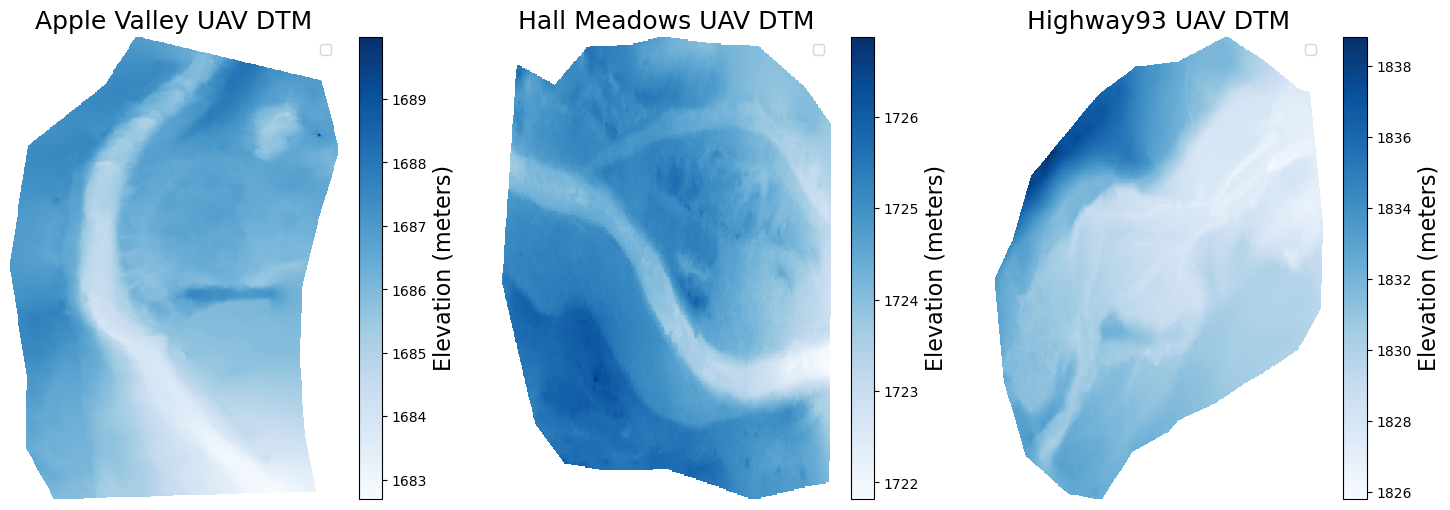

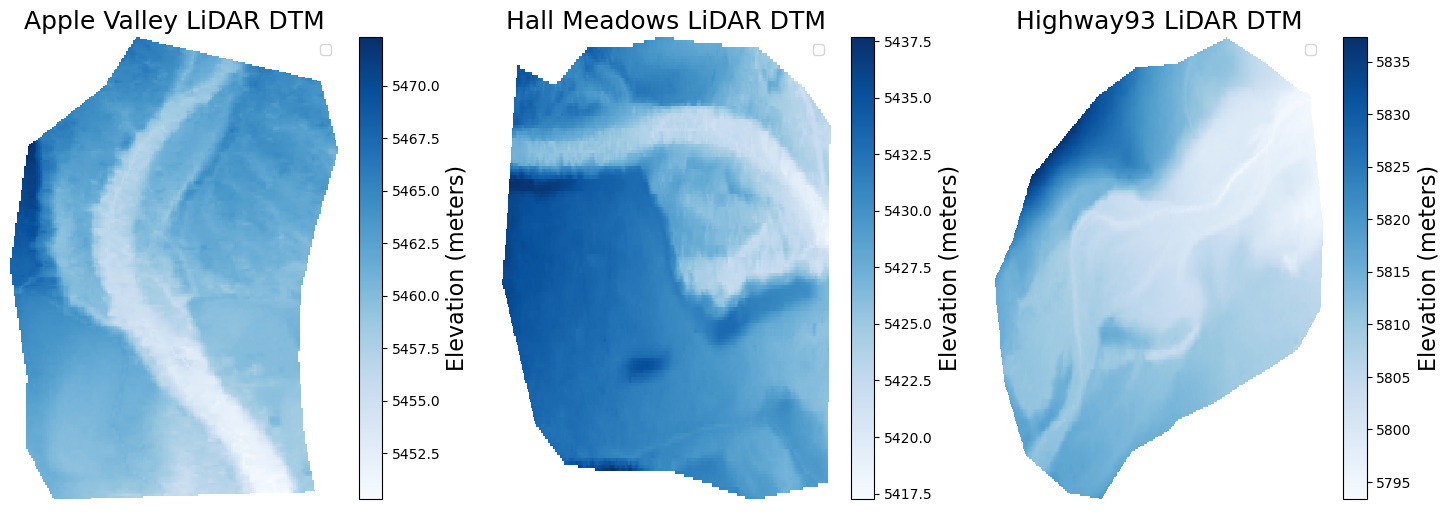

In [8]:
# Call function to plot UAV and Lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley UAV DTM', 
              'Hall Meadows UAV DTM',
              'Highway93 UAV DTM']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['uav_clipped_dtm'], 
                   title=plot_title[i],
                   cbar_label='Elevation (meters)',
                   coarsen=True, xpix=20, ypix=20,
                   fig=fig,ax=axe,
                   cmap='Blues')
    
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley LiDAR DTM', 
              'Hall Meadows LiDAR DTM',
              'Highway93 LiDAR DTM']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['lidar_clipped_dtm'], 
                   title=plot_title[i],
                   cbar_label='Elevation (meters)',
                   coarsen=False,
                   fig=fig, ax=axe,
                   cmap='Blues')

## Plot the LiDAR and UAV DTM histograms

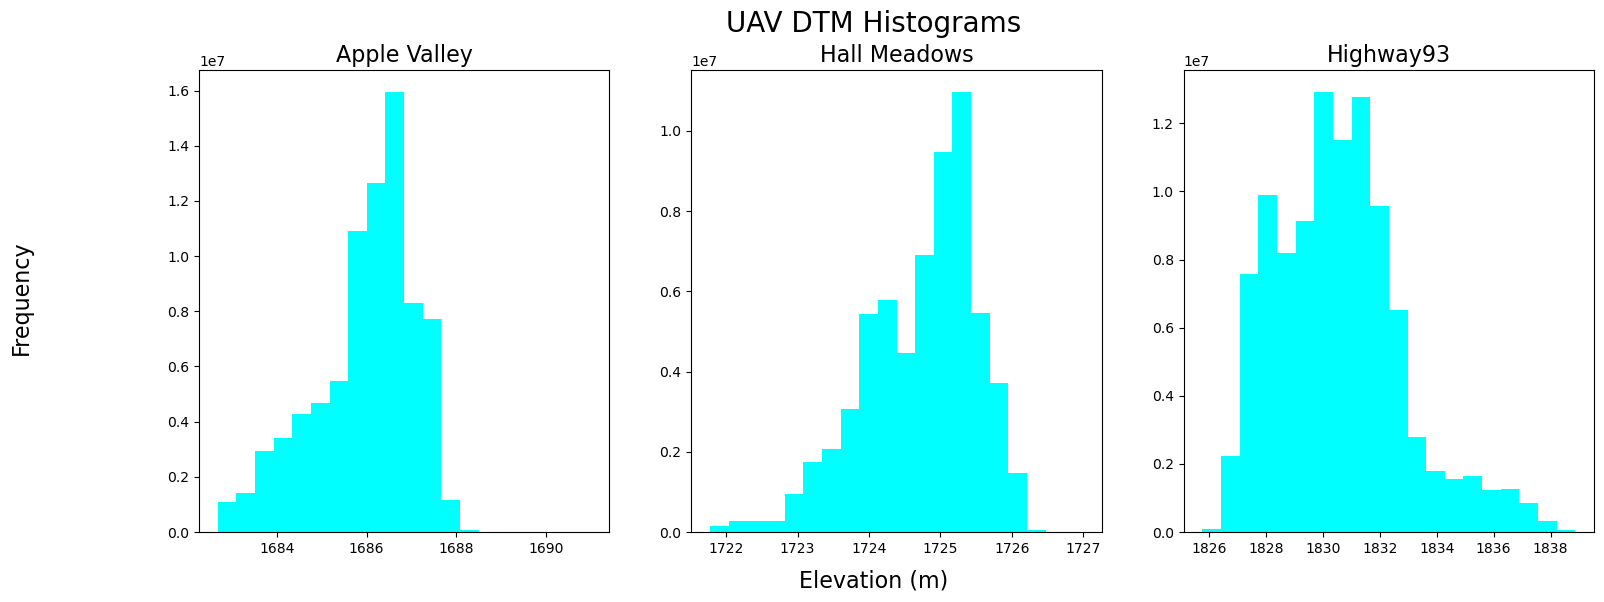

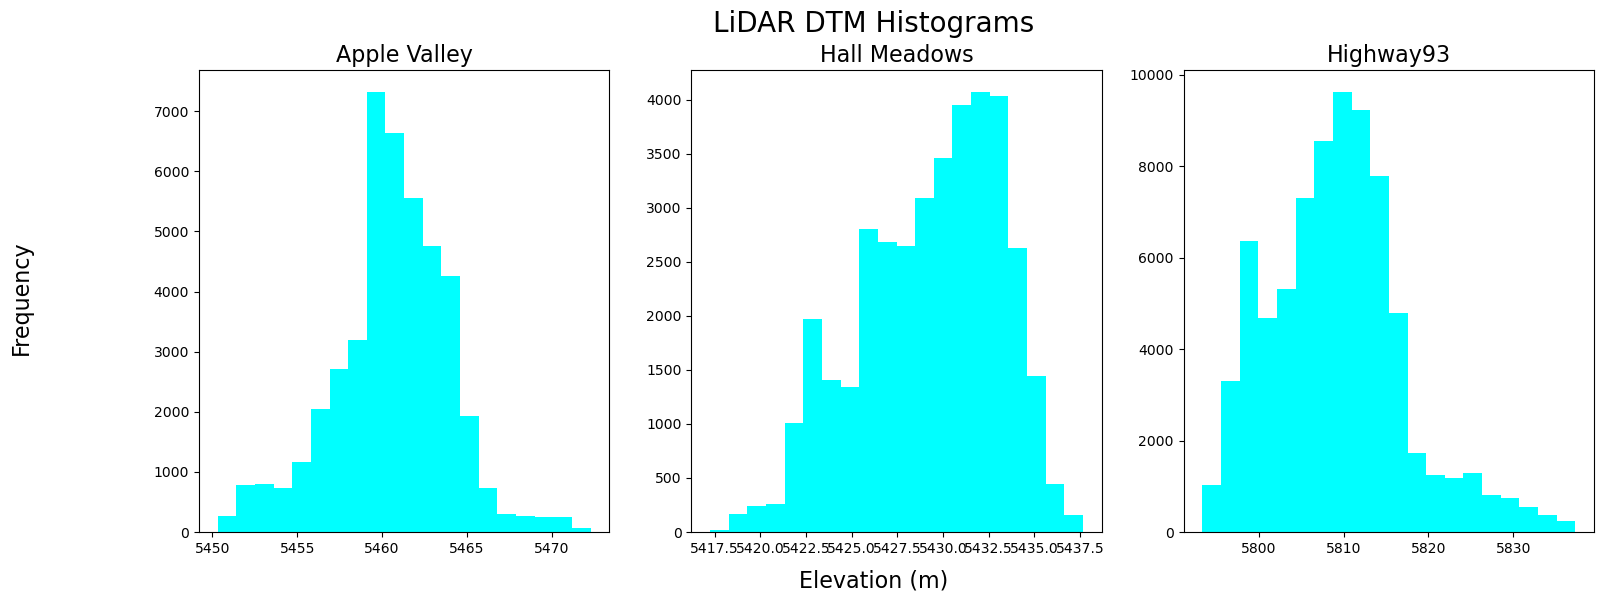

In [9]:
# Call function to plot histogram of lidar and UAV DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['uav_clipped_dtm'], 
               titles=plot_title[i],
               main_title='UAV DTM Histograms',
               color=('cyan'),
               ax=axe, 
               fig=fig)
    
# Call function to plot histogram of lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['lidar_clipped_dtm'], 
               titles=plot_title[i],
               main_title='LiDAR DTM Histograms',
               color=('cyan'),
               ax=axe,
               fig=fig)

# Create LiDAR REMs Using REMMaker Tool

In [13]:
# Create LiDAR REMs for all sites with run_rem_maker_lidar function, add to dict
# Note, the run_rem_maker_lidar function set the directories and paths so that a new
# directory 'rem_maker_lidar' and file ''{}_lidar_dtm_REM.tif' is created
for site in site_data_dictionary:
    load_model.run_rem_maker_lidar(site_name=site['site_name'])
    lidar_rem_path = os.path.join(site['site_name'],
                                  'remmaker_lidar',
                                  '{}_lidar_dtm_REM.tif').format(site['site_name'])
    lidar_remmaker = rxr.open_rasterio(lidar_rem_path, masked=True)
    site['lidar_remmaker'] = lidar_remmaker*0.3048

The LiDAR REMMaker REM already exists. Not running REMMaker
The LiDAR REMMaker REM already exists. Not running REMMaker
The LiDAR REMMaker REM already exists. Not running REMMaker


## Create UAV REMs Using REMMaker Tool

In [12]:
# Create UAV REMs for all sites with run_rem_maker function, add to dict
# The function creates new directory and file similar to the run_rem_maker_lidar function
for site in site_data_dictionary:
    load_model.run_rem_maker(site_name=site['site_name'], k=100)
    uav_rem_path = os.path.join(site['site_name'],
                                  'remmaker',
                                  '{}_dtm_REM.tif').format(site['site_name'])
    site['uav_remmaker'] = rxr.open_rasterio(uav_rem_path, masked=True)

The UAV REMMaker REM already exists. Not running REMMaker
The UAV REMMaker REM already exists. Not running REMMaker
The UAV REMMaker REM already exists. Not running REMMaker


# Plot the UAV and LiDAR Derived REMs

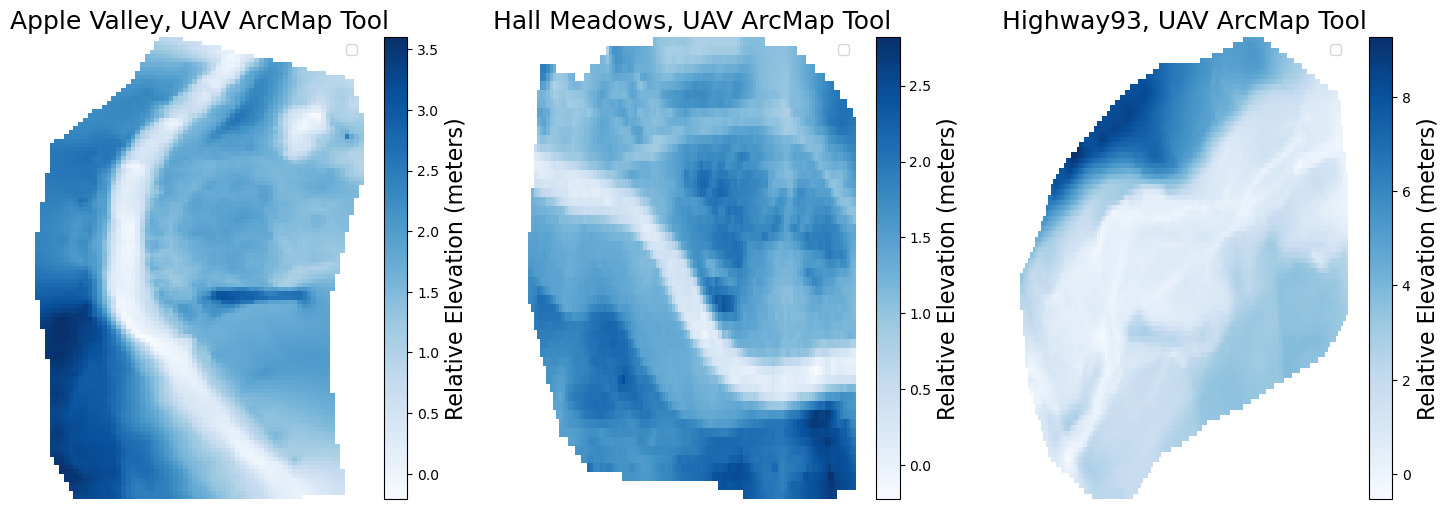

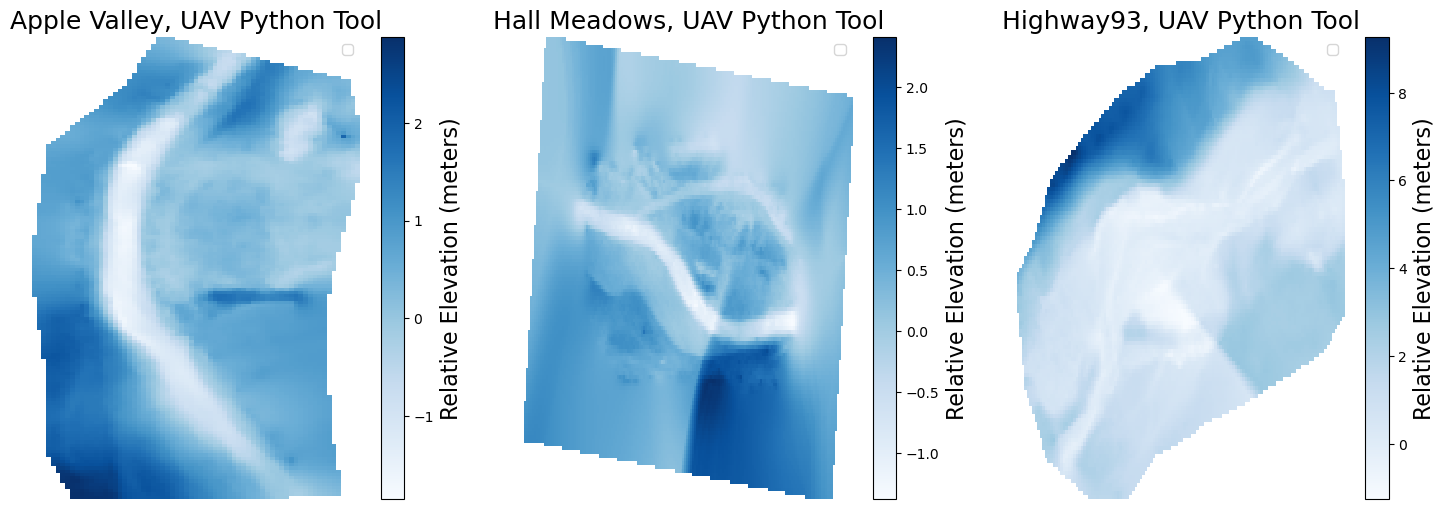

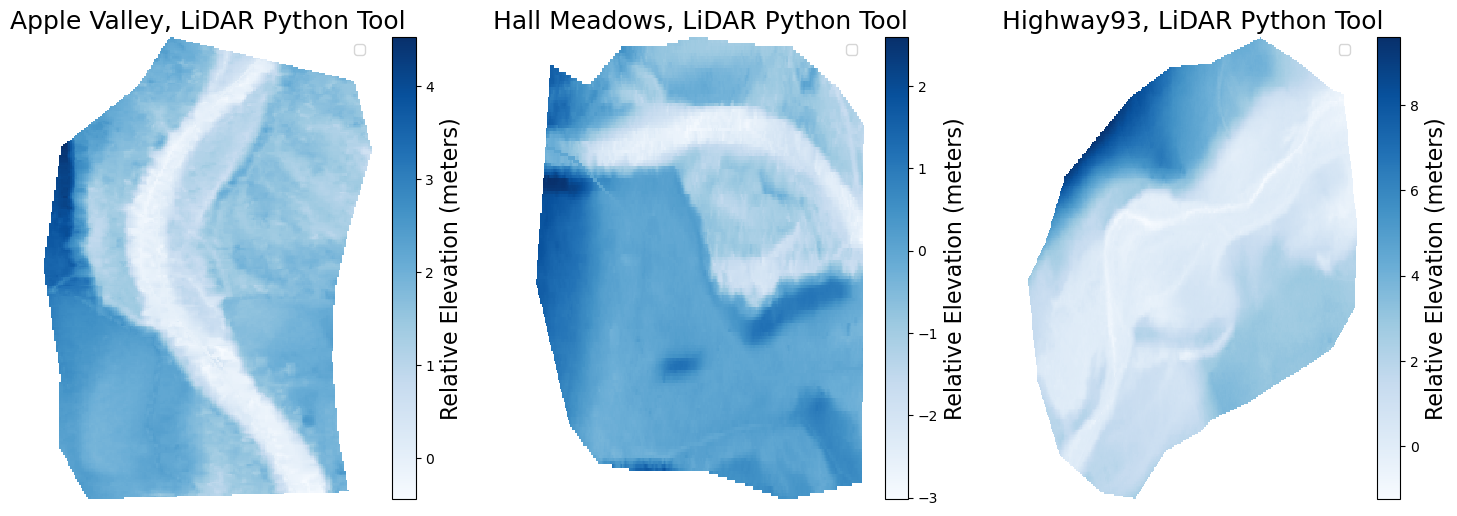

In [15]:
# Call function to plot UAV and LiDAR REMs 
# 1: UAV REMs (CWCB Tool)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley, UAV ArcMap Tool', 
              'Hall Meadows, UAV ArcMap Tool',
              'Highway93, UAV ArcMap Tool']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['uav_rem'], 
                   title=plot_title[i],
                   coarsen=True,
                   cbar_label='Relative Elevation (meters)',
                   xpix=100, ypix=100,
                   fig=fig, ax=axe, 
                   cmap='Blues')

# 2: UAV REMs (REMMaker Tool)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley, UAV Python Tool', 
              'Hall Meadows, UAV Python Tool',
              'Highway93, UAV Python Tool']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['uav_remmaker'], 
                   title=plot_title[i],
                   cbar_label='Relative Elevation (meters)',
                   coarsen=True,
                   xpix=100,
                   ypix=100,
                   fig=fig,
                   ax=axe, 
                   cmap='Blues')
    
# 3: Lidar REMs (REMMaker Tool)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley, LiDAR Python Tool', 
              'Hall Meadows, LiDAR Python Tool',
              'Highway93, LiDAR Python Tool']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['lidar_remmaker'], 
                   title=plot_title[i],
                   cbar_label='Relative Elevation (meters)',
                   coarsen=False,
                   fig=fig,
                   ax=axe,
                   cmap='Blues')

## LiDAR and UAV REMMaker Histograms

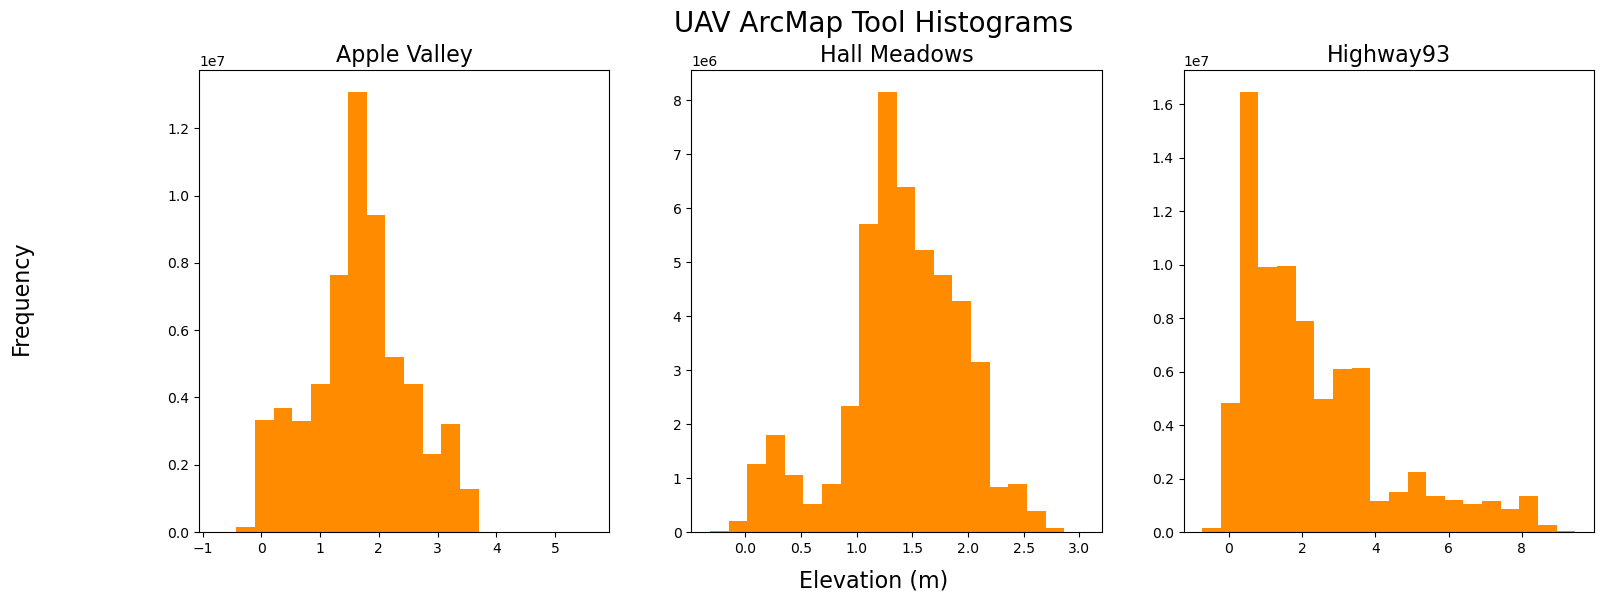

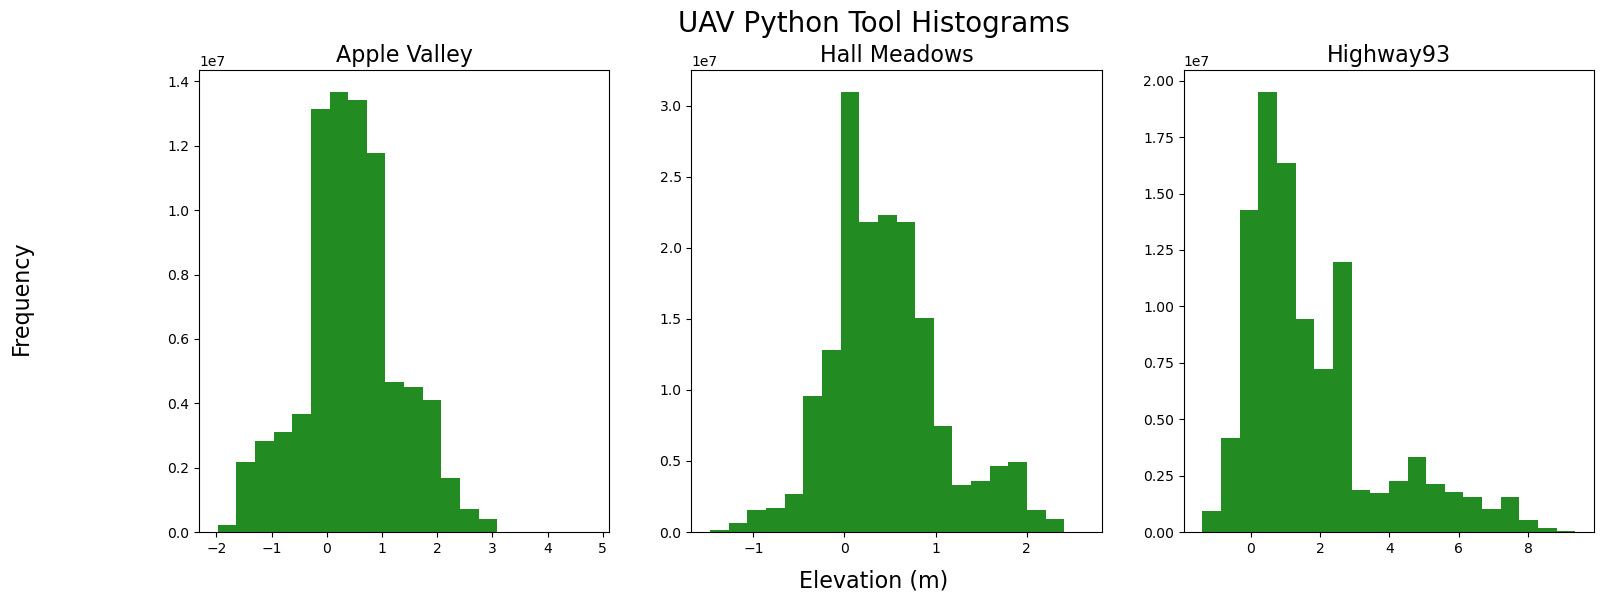

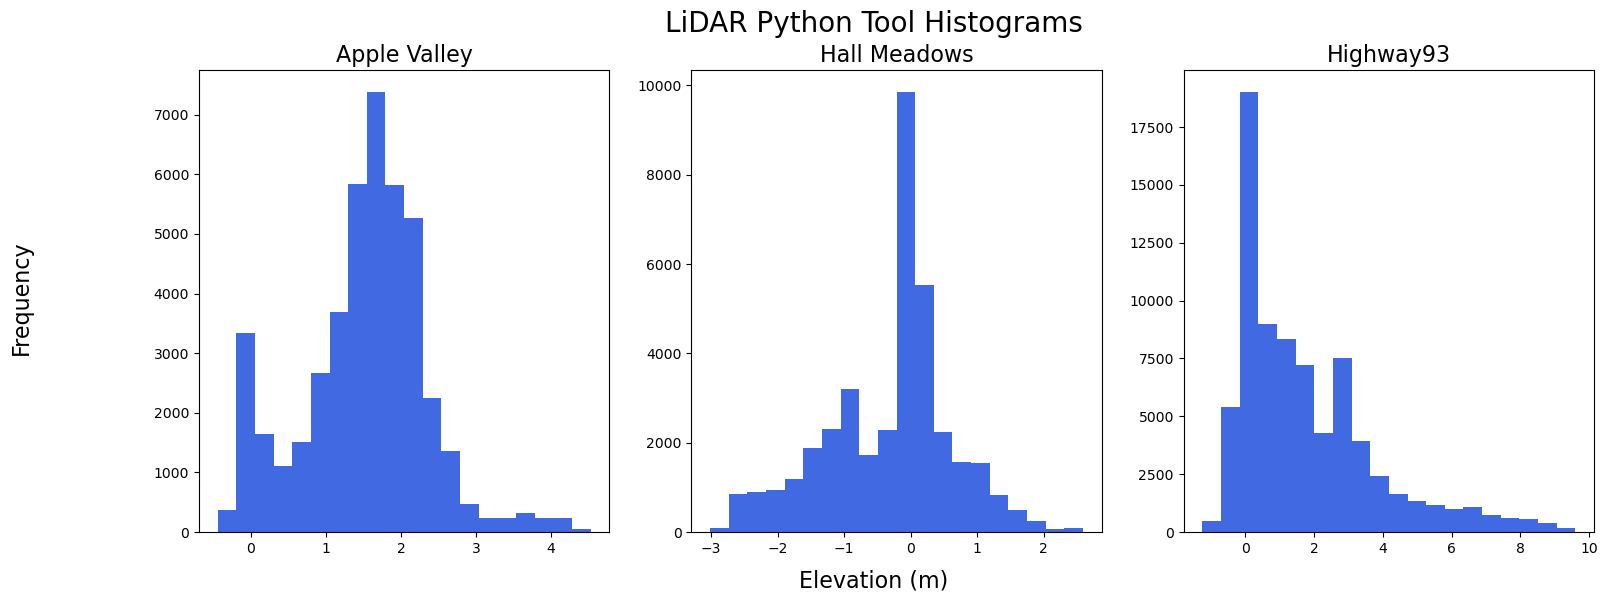

In [16]:
# Call function to plot histograms of LiDAR and UAV REMs
# 1: UAV REMs (CWCB Tool)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['uav_rem'], 
               titles=plot_title[i],
               main_title='UAV ArcMap Tool Histograms',
               color=('darkorange'),
               fig=fig,
               ax=axe)

# 2: UAV REMs (REMMaker Tool)
# Note, I didn't rerun REMMaker with the clipped UAV DTM yet, so the REM appears unclipped
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['uav_remmaker'], 
               titles=plot_title[i],
               main_title='UAV Python Tool Histograms',
               color=('forestgreen'),
               fig=fig,
               ax=axe)
    
# 2: LiDAR REMs (REMMaker Tool)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['lidar_remmaker'], 
               titles=plot_title[i],
               main_title='LiDAR Python Tool Histograms',
               color=('royalblue'),
               fig=fig,
               ax=axe)

## Flood mapping
* A Flood Map shows the area that would become inundated if the water level rises to a given elevation. 
* We conducted a very basic simulation where we sequentially increased the elevation to a threshold elevation that represents the water level from a floodiing event, and assumed that any pixel in the REM raster below the threshhold would become inundated. We conducted the simulation using both the UAV and LiDAR REMs, and then calculated the innundated area for each water level. Finally, we compared the area flooded area produced by using the both the UAV and LiDAR REMs to see how they compare for predicting floods.

In [ ]:
# Delete this cell
# resolutions are off except for lidar DTM - using this resolution for now,
# update later 2.5 ft = 0.762 m
(site_data_dictionary[2]['uav_dtm'].rio.resolution(), 
 site_data_dictionary[2]['uav_rem'].rio.resolution(),
site_data_dictionary[2]['lidar_dtm'].rio.resolution(),
site_data_dictionary[2]['lidar_remmaker'].rio.resolution(),
site_data_dictionary[2]['uav_remmaker'].rio.resolution()) 
# Compute pixel area based on resolution 
        #lidarx, lidary = threshold_lidar_da.rio.resolution()
        #lidar_area=lidarx*lidary
        #uavx, uavy = threshold_uav_da.rio.resolution()
          #uav_area=uavx, uavy

In [ ]:
# Delete this cell
# Area of the highway 93 AOI (bounding polygon), 2.5ft=0.762m
lidar_pixel_size = 0.762
lidar_pixel_area = 0.762*0.762
lidar_count = site_data_dictionary[2]['lidar_remmaker'].size
total_lidar_area = lidar_count*lidar_pixel_area

In [ ]:
# Delete this cell
# Computing UAV pixel size based on known area
uav_count = site_data_dictionary[2]['uav_remmaker'].size
uav_pixel_area = (total_lidar_area/uav_count)
uav_pixel_size = (total_lidar_area/uav_count)**(1/2)

In [17]:
# Function to create flood map arrays - need to update pixel size/area
def flood_map(thresholds, uav_rem, lidar_rem):
    """Creates lists of floodmaps and inundated area
    
    Parameters
    ------------
    thresholds: list
        A list of the water level thresholds.
    uav_rem: dataarray
        Dataarray of the UAV REM for a site.
    lidar_rem: dataarray
        Dataarray of the LiDAR REM for a site.
        
    Returns
    -----------
    flood_dictionary: dictionary
        A dictionary containing lists of uav and lidar floodmaps 
        and inundated areas.
    """
    
    for threshold in threshold_values:
        # The threshold da is all points > threshold
        threshold_uav_da=(uav_rem.where(uav_rem > threshold))
        threshold_lidar_da=(lidar_rem.where(lidar_rem > threshold))
        # Add threshold da to list
        threshold_uav_das.append(threshold_uav_da)
        threshold_lidar_das.append(threshold_lidar_da)
        
        # Compute pixel area based on resolution - use lidar_dtm values for now 2.5 ft = 0.762 m
        uav_pixel_area = 0.020850267865945408**2
        lidar_pixel_area =  0.762**2

        # Compute area inundated - uav
        total_uav_count = uav_rem.size
        valid_uav_count = int(threshold_uav_da.count().compute())
        # Add inundated area to list = nan values*pixel area
        uav_area_list.append(
            (total_uav_count - valid_uav_count)*uav_pixel_area)

        # Compute area inundated - lidar
        total_lidar_count = lidar_rem.size
        valid_lidar_count = int(threshold_lidar_da.count().compute())
        lidar_area_list.append(
            (total_lidar_count - valid_lidar_count)*lidar_pixel_area)

        # Create a dictionary to store the lists of dataarrays
        flood_dictionary = {'threshold_uav_das': threshold_uav_das,
                     'threshold_lidar_das': threshold_lidar_das,
                     'uav_area_list': uav_area_list,
                     'lidar_area_list': lidar_area_list}
    
    return flood_dictionary

In [27]:
# Create lists of floodmaps at different water level thresholds
threshold_values = np.arange(-.5, .5, 0.05)
threshold_lidar_das = []
threshold_uav_das = []
uav_area_list = []
lidar_area_list = []

applevalley_flood_dictionary = flood_map(thresholds = threshold_values, 
                                         uav_rem = site_data_dictionary[0]['uav_remmaker'],
                                         lidar_rem = site_data_dictionary[0]['lidar_remmaker'])
threshold_lidar_das = []
threshold_uav_das = []
uav_area_list = []
lidar_area_list = []
highway93_flood_dictionary = flood_map(thresholds = threshold_values, 
                                       uav_rem = site_data_dictionary[2]['uav_remmaker'],
                                       lidar_rem = site_data_dictionary[2]['lidar_remmaker'])

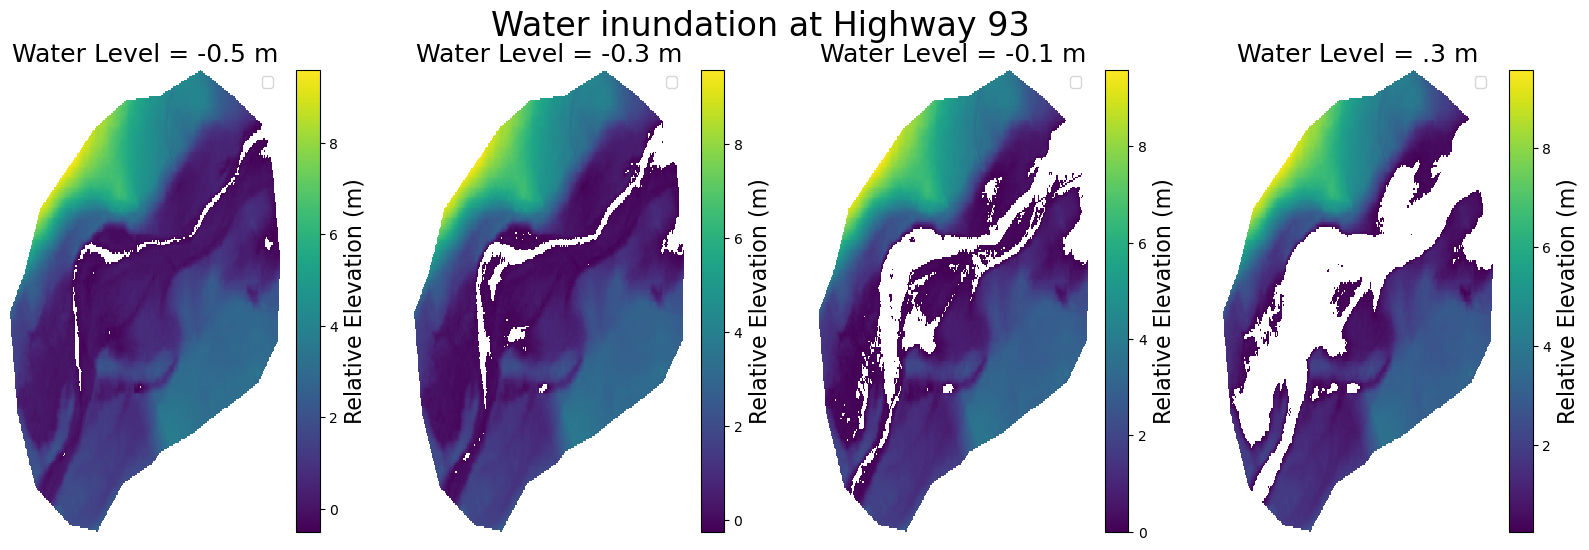

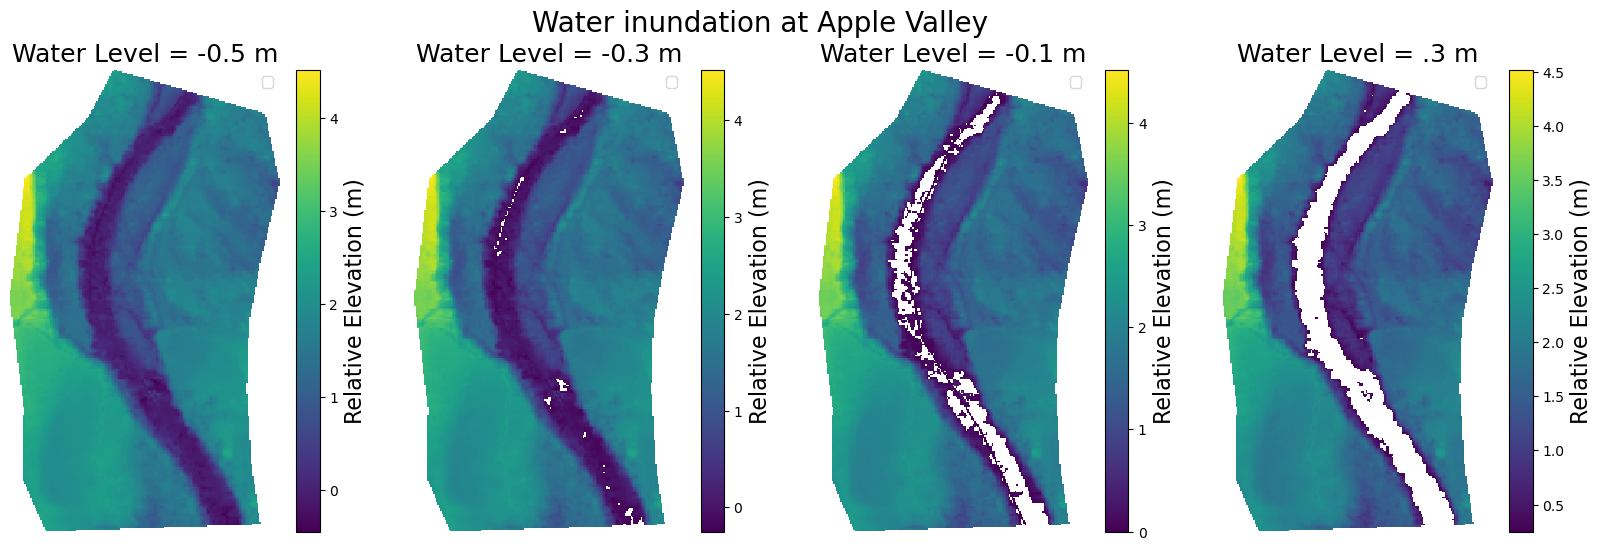

In [29]:
# Plot the lidar floodmaps - update subplots to match len(threshold_values)
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
plot_title = ['Water Level = -0.5 m', 'Water Level = -0.3 m', 
              'Water Level = -0.1 m', 'Water Level = .3 m']
fig.suptitle('Water inundation at Highway 93', fontsize=24)

for i, axe in enumerate(axes.flatten()):
    load_model.plot_model(model=highway93_flood_dictionary['threshold_lidar_das'][i*5], 
               title=plot_title[i],
               cbar_label='Relative Elevation (m)',
               coarsen=False,
                #   xpix=100,
                 #  ypix=100,
                   fig=fig,
                   ax=axe,
                   cmap='viridis')

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
plot_title = ['Water Level = -0.5 m', 'Water Level = -0.3 m', 
              'Water Level = -0.1 m', 'Water Level = .3 m']
fig.suptitle('Water inundation at Apple Valley', fontsize=20)

for i, axe in enumerate(axes.flatten()):
    load_model.plot_model(model=applevalley_flood_dictionary['threshold_lidar_das'][i*5], 
               title=plot_title[i],
               cbar_label='Relative Elevation (m)',
               coarsen=False,
               #    xpix=100,
                #   ypix=100,
                   fig=fig,
                   ax=axe, 
                   cmap='viridis')

## Increased connectivity = greater inundation and less water downstream

In [30]:
# ADefine plots for simulation
def plot_floodmap(plot_da, site, vmin, vmax):
    ###
    # Plots the floodmap at each threshold
    ###
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    im = plot_da.plot(ax=ax, add_colorbar=False, 
                      cmap='viridis', robust=True, 
                      vmin=np.nanmin(plot_da), vmax=np.nanmax(plot_da))
    cbar = fig.colorbar(im)
    cbar.set_label('Relative Elevation (m)', fontsize=16)
    ax.set_title('Inundation at {} over increasing water levels'.format(site),
          fontsize=20)
  
    # Hide x and y axes labels and ticks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend('off')
    ax.axis('off')
    plt.show()

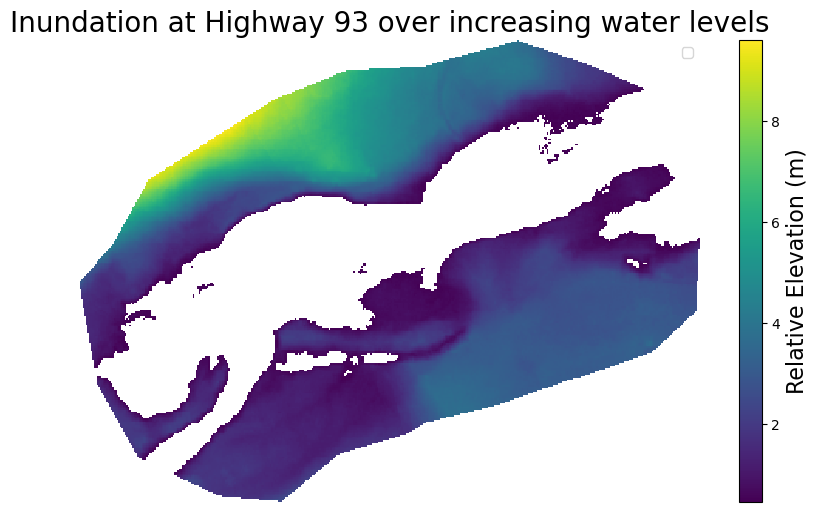

In [31]:
# Highway 93 simulation
for threshold_da in highway93_flood_dictionary['threshold_lidar_das']:
    plot_floodmap(plot_da=threshold_da, site='Highway 93', vmin = 0, vmax = 8)
    sleep(0.01)
    clear_output(wait=True)

## Decreased connectivity = less inundation and more water travelling downstream

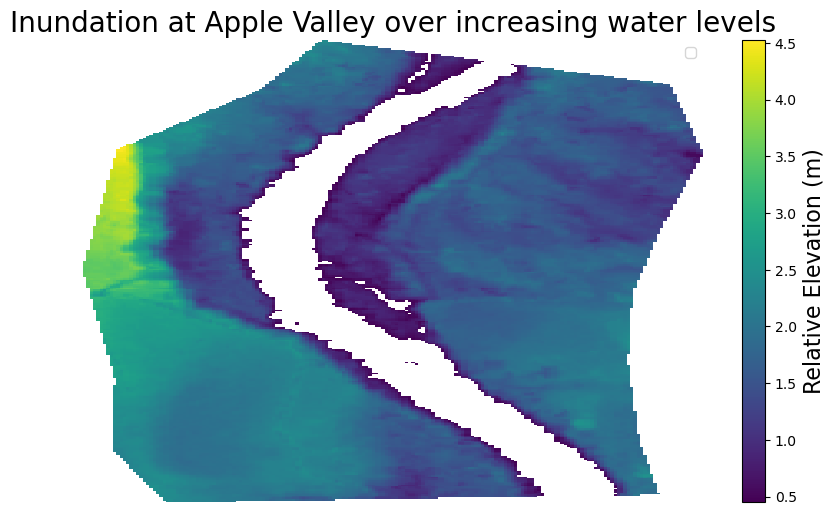

In [32]:
# Apple Valley simulation
for threshold_da in applevalley_flood_dictionary['threshold_lidar_das']:
    plot_floodmap(plot_da=threshold_da, site='Apple Valley', vmin = 0, vmax = 2.5)
    sleep(0.01)
    clear_output(wait=True)

In [ ]:
# Delete this cell
# Save plot frames for animation
gif_dir = 'applevalley_gif'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

for i, threshold_da in enumerate(applevalley_flood_dictionary['threshold_lidar_das']):
    # Make plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    im = applevalley_flood_dictionary['threshold_lidar_das'][i].plot(ax=ax, add_colorbar=False, 
                      cmap='gist_earth', robust=True, vmin = 0, vmax = 25)
    cbar = fig.colorbar(im)
    cbar.set_label('Relative Elevation (m)', fontsize=14)
    ax.set_title('Inundation at {} over increasing water levels'.format(site),
          fontsize=16)
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend('off')
    ax.axis('off')
    plt.show()
    # Save to path
    fig_path=os.path.join(gif_dir, 'applevalley_step_{}.jpg'.format(i))
    fig.savefig(fig_path)
    #clear_output()

In [ ]:
# Delete this cell
# Save frames as gif
import glob
from PIL import Image
gif_dir = 'applevalley_gif'
frames=[]
#def make_gif(frame_folder):
for image in glob.glob(gif_dir + '/*.jpg'):
    frames.append(Image.open(image))

        
frame_one = frames[0]
frame_one.save("applevalley_flood.gif", format="GIF", append_images=frames,
               save_all=True, duration=10, loop=0)

## Comparing LiDAR and UAV Outputs
Are the inundated areas estimated with the UAV and LiDAR outputs comparable?
* The "rate" of inundation is similar between the UAV and LiDAR data, indicating that the REMs had similar distributions and corroborates the histograms.
* The area of inundation is lower for the LiDAR compared with the UAV data. This could be due to a lack of accuracy in the LiDAR data due to lack of reference points and could probably be corrected by using ground control points if available.

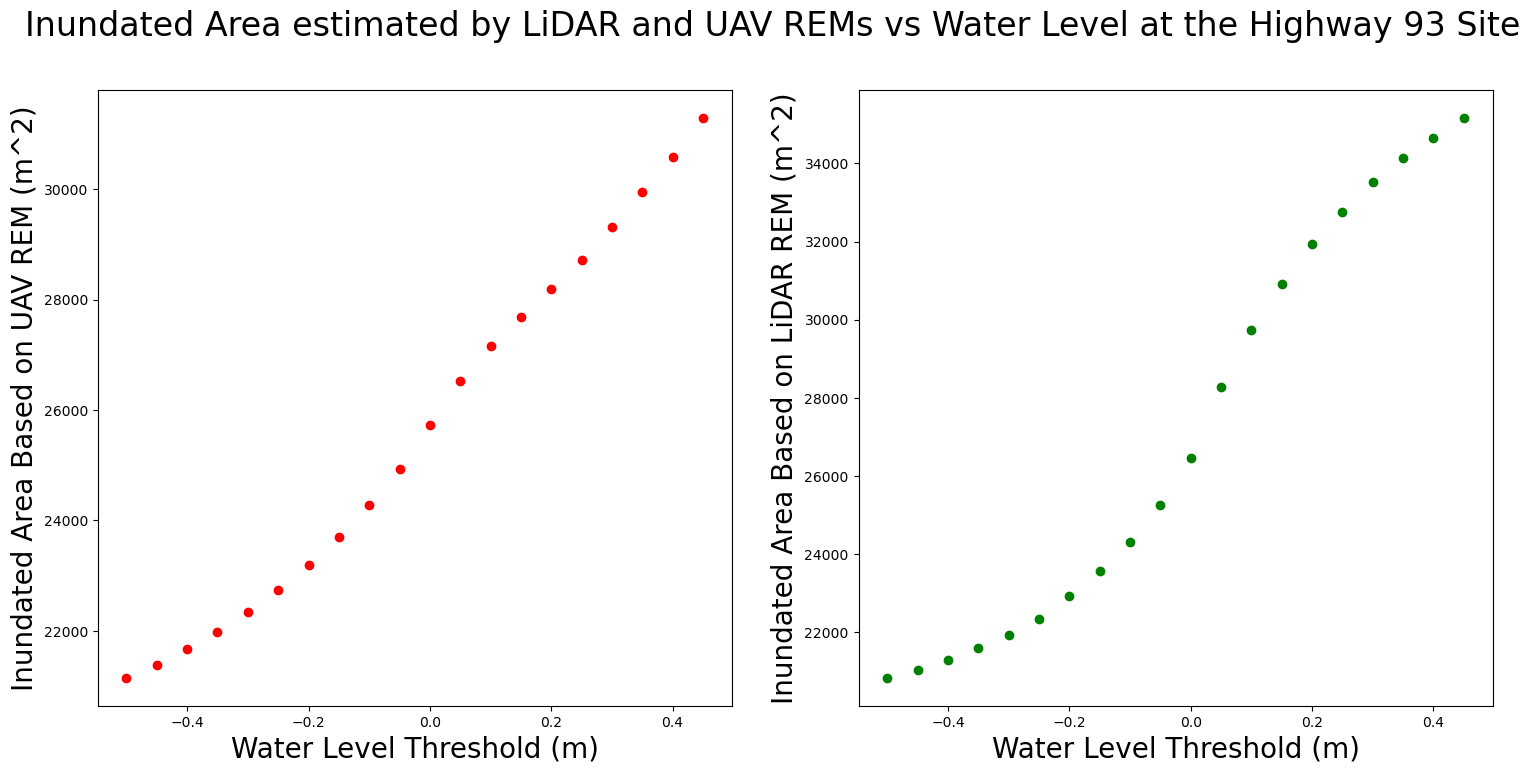

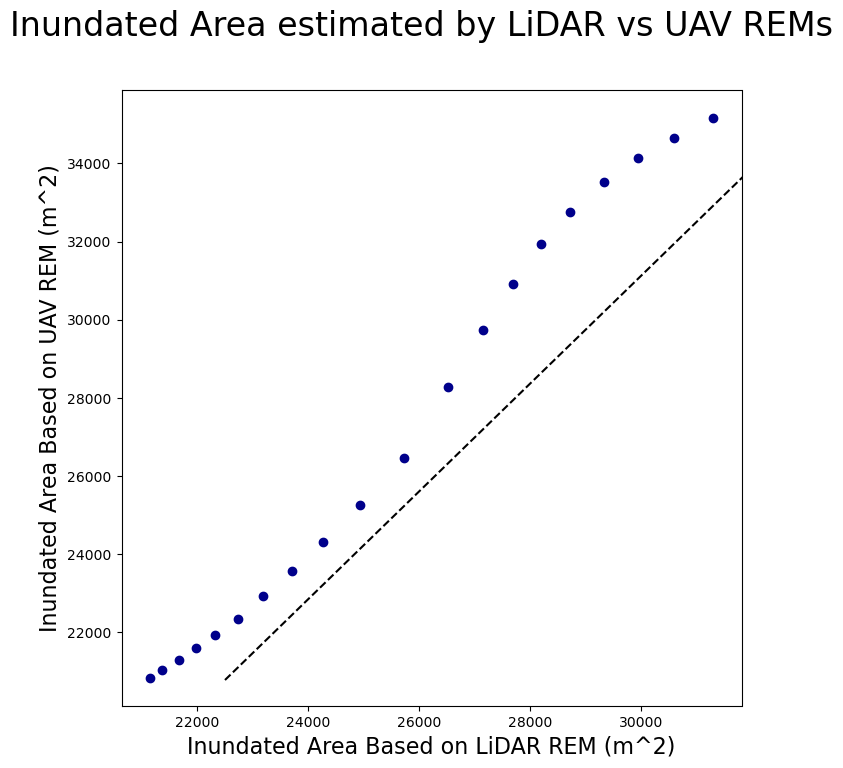

In [33]:
# Optional -?
# Plot of UAV vs LiDAR Inundated Area for one site
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Inundated Area estimated by LiDAR and UAV REMs '
             'vs Water Level at the Highway 93 Site', fontsize = 24)
ax1.scatter(threshold_values, 
            highway93_flood_dictionary['uav_area_list'], color='red')
ax1.set_ylabel('Inundated Area Based on UAV REM (m^2)', fontsize=20)
ax1.set_xlabel('Water Level Threshold (m)', fontsize=20)

ax2.scatter(threshold_values, 
            highway93_flood_dictionary['lidar_area_list'],
           color='green')
ax2.set_ylabel('Inundated Area Based on LiDAR REM (m^2)', fontsize=20)
ax2.set_xlabel('Water Level Threshold (m)', fontsize=20)


# Plot UAV vs LiDAR Area
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle('Inundated Area estimated by LiDAR vs UAV REMs', 
             fontsize = 24)
ax.scatter(highway93_flood_dictionary['uav_area_list'], 
           highway93_flood_dictionary['lidar_area_list'],
          color='darkblue')
ax.plot((0,1), (0,1), transform=ax1.transAxes, ls='--', c='k')

ax.set_ylabel('Inundated Area Based on UAV REM (m^2)', fontsize=16)
ax.set_xlabel('Inundated Area Based on LiDAR REM (m^2)', fontsize=16)

plt.show()